<a href="https://colab.research.google.com/github/4cea2/7506R-2C2023-GRUPO26/blob/main/7506R_TP1_GRUPO26_CHP3_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Trabajo practico 1 - Checkpoint 3**
**Grupo**: 26

**Integrantes**:

Garcia, Nicolas

Vallcorba, Agustin

Carbajal Robles, Kevin Emir

## **Librerias y carga del data set**

In [ ]:
!pip install xgboost

In [ ]:
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import tensorflow as tf

from sklearn.model_selection import train_test_split

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.datasets import load_iris
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

Cargamos el dataset de train y test, que es el que obtuvimos en el checkpoint 2.

De igual manera lo haremos para el dataset de test y el de train original, tambien el obtenido del chp1.

In [ ]:
#Dataset de entrenamiento
ds_train = pd.read_csv('sample_data/ds_train_limpio.csv')

#Dataset de test
ds_test = pd.read_csv("sample_data/ds_test_limpio.csv")


#Dataset de test
ds_test_orig = pd.read_csv("sample_data/hotels_test.csv")

#Dataset de entrenamiento chp1
ds_train_chp1 = pd.read_csv('sample_data/ds_train_chp1.csv')

#Dataset de entrenamiento original
ds_train_orig = pd.read_csv("https://drive.google.com/u/0/uc?id=1tjlunFxE63XIpYjWk8SPm2XPxixu8SW4&export=download")

## **Clasificadores**

Para entrenar cada clasificador, haremos una division del dataset de train.

Entrenaremos con un 70%, y dejaremos un 30% para testear, al igual que el checkpoint 2.

In [ ]:
#Creo un dataset con los features que voy a usar para clasificar
ds_train_x=ds_train.drop(['is_canceled'], axis='columns', inplace=False)

#Creo un dataset con la variable target
ds_train_y = ds_train['is_canceled'].copy()

#Genero los conjuntos de train y test
x_train, x_test, y_train, y_test = train_test_split(ds_train_x,
                                                    ds_train_y,
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=2) #semilla

En todos los clasificadores, evaluaremos su performance, explicaremos todas las métricas y mostraremos su matriz de confusion.

Definiremos una funcion para calcular las metricas y su matriz de confusion.

In [ ]:
def metricas_y_matriz_confusion(y_prediccion, y_testeo):
  #Calculo las métricas en el conjunto de evaluación
  accuracy=accuracy_score(y_testeo,y_prediccion)
  recall=recall_score(y_testeo,y_prediccion)
  f1=f1_score(y_testeo,y_prediccion,)
  precision=precision_score(y_testeo,y_prediccion)
  cm = confusion_matrix(y_testeo, y_prediccion)

  print("Accuracy: "+str(accuracy))
  print("Recall: "+str(recall))
  print("Precision: "+str(precision))
  print("f1 score: "+str(f1))

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicción')
  plt.ylabel('Valor Real')
  plt.title('Matriz de Confusión')
  plt.show()

### **KNN - K-Nearest Neighbors**

Pruebo primero con 3 vecinos

In [ ]:
param_grid = {
    'n_neighbors': [3],  # Cantidad de vecinos
    'weights': ['uniform'],  # Peso de los vecinos
    'metric': ['minkowski'],  # Métricas de distancia
}

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=kfold, scoring='accuracy')
grid_search.fit(x_train, y_train)


best_params = grid_search.best_params_
best_knn = grid_search.best_estimator_


y_pred = best_knn.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", accuracy)
print("Cantidad de aciertos:", np.sum(y_test == y_pred))
print("Totales:", len(y_test))





Accuracy on test set: 0.7356639566395664
Cantidad de aciertos: 13573
Totales: 18450


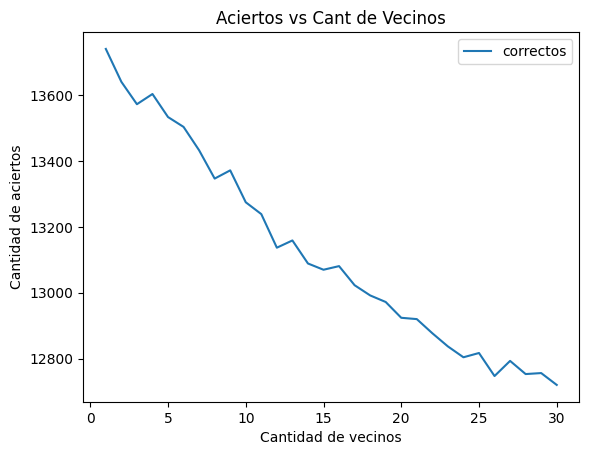

In [ ]:
#ploteo
knn.get_params()
metrics = []

for n in range(1,31):
  knn_test = KNeighborsClassifier(n_neighbors=n)
  knn_test.fit(x_train, y_train)
  y_pred = knn_test.predict(x_test)
  metrics.append((n, (y_test == y_pred).sum()))

df_metrics = pd.DataFrame(metrics, columns=['cant_vecinos', 'correctos'])
ax = df_metrics.plot(x='cant_vecinos',
                     y='correctos',
                     title='Aciertos vs Cant de Vecinos')
ax.set_ylabel('Cantidad de aciertos')
ax.set_xlabel('Cantidad de vecinos')
plt.show()

Entre 1 y 9 vecinos podemos ver que se da la mayor cantidad de aciertos, luego de esto tenemos menos de un 70% de aciertos, por lo que no creemos conveniente seguir analizando con más vecinos.

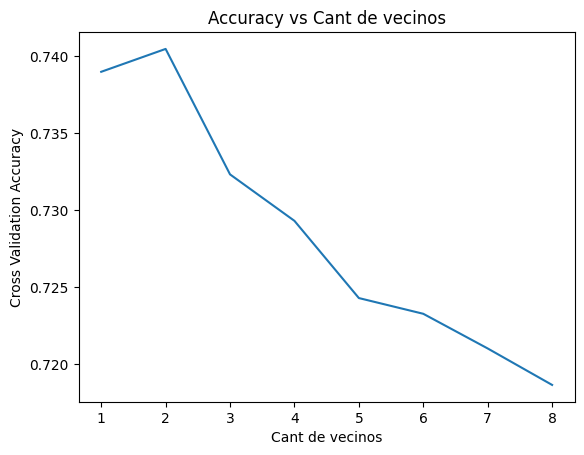

In [ ]:
from sklearn.model_selection import cross_val_score
k_scores = []
k_range = range(1,9)

for n in k_range:
  knn_new_range = KNeighborsClassifier(n_neighbors=n)
  scores = cross_val_score(knn_new_range, x_train, y_train, cv=10, scoring='accuracy')
  #knn_test.fit(x_train, y_train)
  #y_pred = knn_test.predict(x_test)
  k_scores.append(scores.mean())

#ploteo accuaracy vs cant de vecinos
#df_metrics = pd.DataFrame(metrics, columns=['cant_vecinos', 'correctos'])
plt.plot(k_range, k_scores)
plt.xlabel('Cant de vecinos')
plt.ylabel('Cross Validation Accuracy')
plt.title('Accuracy vs Cant de vecinos')
plt.show()

Teniendo en cuenta esto, incluso podemos descartar aún una mayor cantidad de vecinos. Realizaremos un último clasificador y entrenamiento con hasta 5 vecinos y una gama más amplia de métricas, algorítmos y formas de calcular la distancia.

In [ ]:
#Utilizaremos el algorítmo RandomizedSearch para poder entrenar a nuestro clasificador
from sklearn.model_selection import RandomizedSearchCV

params_grid = { 'n_neighbors': range(1,5),
                'weights': ['distance', 'uniform'],
                'algorithm': ['ball_tree', 'kd_tree'],
                'metric': ['euclidean', 'manhattan', 'infinity']}

tuned_knn = KNeighborsClassifier()

rand_search = RandomizedSearchCV(tuned_knn, params_grid, cv=10, scoring='accuracy', n_iter=8, random_state=5)

rand_search.fit(x_train, y_train)
rand_search.cv_results_['mean_test_score']

array([0.73203252, 0.75454123, 0.74896632, 0.72943089, 0.73340302,
       0.74111498, 0.74113821, 0.73921022])

Ahora busco el mejor hiperparámetro con la mejor métrica

In [ ]:
print(rand_search.best_params_)
print(rand_search.best_score_)

{'weights': 'distance', 'n_neighbors': 1, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
0.7545412311265969


Ahora agarramos al mejor estimador, realizamos una predicción con él y obtenemos su precisión.

In [ ]:
best_knn = rand_search.best_estimator_
y_pred = best_knn.predict(x_test)
accuracy_score(y_test, y_pred)

0.7605420054200542

Accuracy: 0.7605420054200542
Recall: 0.7889066666666666
Precision: 0.7520081342145399
f1 score: 0.7700156168662156


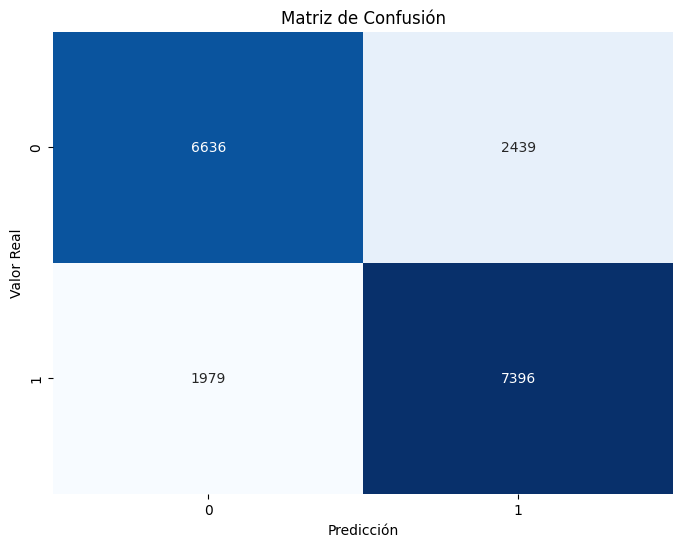

In [ ]:
metricas_y_matriz_confusion(y_pred, y_test)

### **SVM - Support Vector Machines**

Las Máquinas de Soporte Vectorial, conocidas como SVM (por sus siglas en inglés, Support Vector Machines), constituyen una técnica de aprendizaje automático supervisado. A pesar de su concepción inicial para abordar tareas de clasificación binaria, actualmente se utilizan con éxito en la resolución de desafíos más sofisticados, tales como problemas de regresión, agrupamiento y clasificación multiclase.

Los SVM se pueden clasificar como clasificadores lineales, ya que buscan establecer un hiperplano o un conjunto de hiperplanos en el espacio original o en un espacio de características transformado, según la linealidad o no de los datos. En el caso de datos linealmente separables, se encuentra un hiperplano en el espacio original que divide las clases. Cuando los datos no son linealmente separables, se aplica una transformación de kernel para llevar los datos a un espacio de características aumentado, donde se busca una separación lineal.

Los **kernels** en una SVM son funciones matemáticas que se utilizan para transformar el espacio de características original de los datos en un espacio de características de mayor dimensionalidad. Esta transformación es fundamental en las SVM, ya que permite que los datos sean más fácilmente separables en el espacio de características transformado, lo que puede hacer que el proceso de clasificación sea más efectivo.

#### **Entrenamiento**

**Datos**

Antes de construir el clasificador SVM y variar los parametros y kernels, hicimos un mini-entrenamientos para ver que tanto varia en su prediccion este clasificador, si los datos con lo cuales entrena, estan escalados, normalizados o sin ningun tipo de pre-procesamiento.


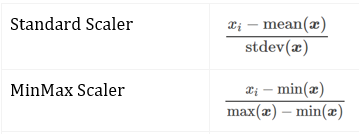

Obtuvimos una mejor metrica de f1_score con los datos escalados con MinMaxScaler, por lo tanto, entrenaremos el clasificador con estos datos.

In [ ]:
#Armo una version escalada con minmax (media=0 , var=1  )
min_max_scaler = preprocessing.MinMaxScaler()
x_train_minmax = min_max_scaler.fit_transform(x_train)
x_test_minmax  = min_max_scaler.transform(x_test)

**Kernels**

Para el entrenamiento con los kernels, usamos 3 tipos de kernels:

*   **Lineal**

*   **Polinomico**

*   **Radial**

En cada uno de estos entrenamientos, definimos el siguiente hiperparametro:


*   **C** : Parámetro de regularización, debe ser estrictamente positiva. Evita el overfitting. Mientras mas grande sea este valor, menor regularizacion, y viceversa.

Entre los 3 kernels, vimos que el que menos tardaba y mejor prediccion tenia, era con el kerner **lineal**. Por lo cual, usaremos este kernel para hacer el entrenamiento y buscar los mejores hiperparametros.


**Hiperparametros**

Elegiremos el Random SearchCV para buscar algunos hiperparametros de interes:

*   **loss**: Puede tomar uno de los valores: 'hinge' o 'squared_hinge'. 'Hinge' se utiliza para la pérdida hinge, que es la pérdida de máquina de vectores de soporte tradicional. 'squared_hinge' se utiliza para la pérdida de bisagra cuadrada, que es más suave que la pérdida hinge y puede ser útil en algunos casos. No se admite la combinación de penalización='l1' y pérdida='hinge'.

*   **penalty**: Controla el tipo de regularización. Puede ser 'l1' para regularización L1 o 'l2' para regularización L2.

*   **dual**: Este parámetro controla si se utiliza la formulación "dual" o "primal" para el problema de optimización. El valor predeterminado es True, lo que significa que se utiliza la formulación dual. Puedes establecerlo en False para utilizar la formulación primal, que es más eficiente cuando el número de características es grande.

*   **multi_class**: Indica cómo manejar la clasificación multiclase. Puede ser 'ovr' (uno contra el resto) o 'crammer_singer' (una formulación más compleja para la clasificación multiclase). El valor predeterminado es 'ovr'.



In [ ]:
#Cantidad de combinaciones de parametros que quiero probar
n=10

#Conjunto de parámetros que quiero usar
params_grid = {'C': [20, 40, 60, 80, 100],
               'loss':['squared_hinge', 'hinge'],
               'penalty': ['l1', 'l2'],
               'dual': [True, False],
               'multi_class': ['ovr', 'crammer_singer'],
               }


#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado - arma los folds
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
clf = LinearSVC()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=clf,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n,
                              )

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train_minmax,y_train);

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Observamos los mejores hiperparametros y sus respectivos f1_score.

In [ ]:
#Mejores hiperparametros del clasificador
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

{'penalty': 'l1', 'multi_class': 'crammer_singer', 'loss': 'squared_hinge', 'dual': False, 'C': 80}
0.7992857662159525


In [ ]:
randomcv.cv_results_['mean_test_score']

array([0.79202928, 0.79928577,        nan, 0.79910042, 0.79920106,
       0.79913594, 0.79900567,        nan, 0.79870313, 0.79876248])

Creamos el clasificador y lo entrenamos.

In [ ]:
clf = LinearSVC().set_params(**randomcv.best_params_)

#Entreno el clasificador
clf.fit(x_train_minmax,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=80, dual=False, multi_class='crammer_singer', penalty='l1')

Predecimos.

In [ ]:
y_pred = clf.predict(x_test_minmax)

Calculamos las metricas de interes y su matriz de confusion.

Accuracy: 0.7970731707317074
Recall: 0.78656
Precision: 0.8088186903586706
f1 score: 0.7975340687865023


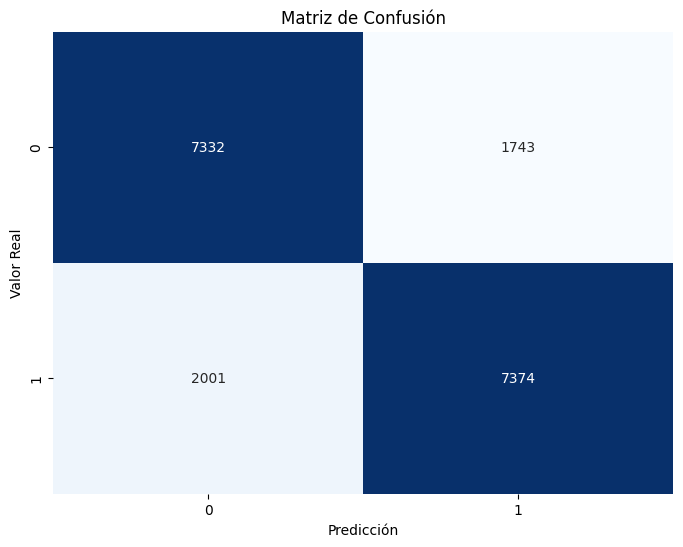

In [ ]:
metricas_y_matriz_confusion(y_pred, y_test)

Aplicaamos la version escalada para el test real, asi al momento de predecir, usamos los datos escalados, ya que entrenamos el modelo de la misma forma.

In [ ]:
x_submission  = min_max_scaler.transform(ds_test)

### **RF - Random Forest Clasificación**

Mejores hiperparámetros: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Precisión promedio con k-fold Cross Validation: 0.8748199767711963
Precisión en el conjunto de prueba: 0.8785907859078591
Accuracy: 0.8785907859078591
Recall: 0.86272
Precision: 0.8945913062714301
f1 score: 0.8783666377063423


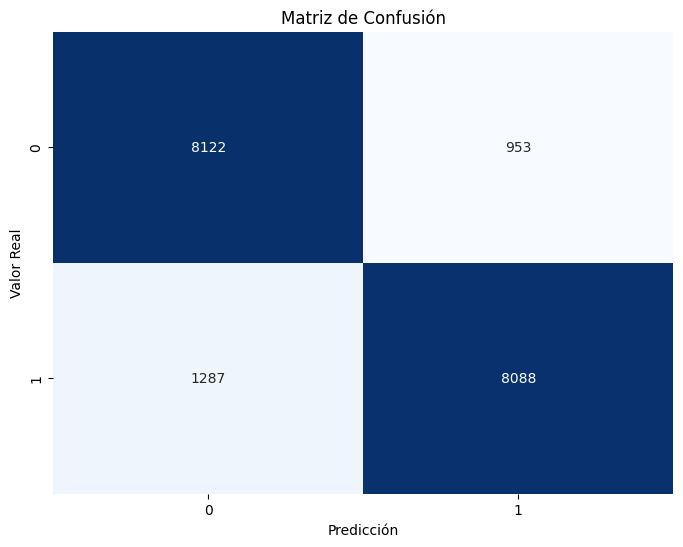

In [ ]:
#Cantidad de combinaciones de parametros que quiero probar
n=10

#Crear el clasificador Random Forest
rf_classifier = RandomForestClassifier()

#Definir un espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

#Realizar k-fold Cross Validation para evaluar el rendimiento con diferentes hiperparámetros
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#Realizar la búsqueda de hiperparámetros con GridSearchCV
grid_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_grid, cv=kf, scoring='accuracy', n_iter=n)
grid_search.fit(x_train, y_train)

#Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

#Entrenar un clasificador Random Forest con los mejores hiperparámetros en el conjunto de datos completo
best_rf_classifier = grid_search.best_estimator_

#Evaluar el rendimiento del clasificador con los mejores hiperparámetros utilizando k-fold Cross Validation
k_fold_scores = cross_val_score(best_rf_classifier, x_train, y_train, cv=kf, scoring='accuracy')

#Calcular y mostrar la precisión promedio con k-fold Cross Validation
mean_accuracy = k_fold_scores.mean()
print("Precisión promedio con k-fold Cross Validation:", mean_accuracy)

#Evaluar el rendimiento del modelo en el conjunto de prueba
test_accuracy = best_rf_classifier.score(x_test, y_test)
print("Precisión en el conjunto de prueba:", test_accuracy)

#Obtener predicciones en el conjunto de prueba
y_pred = best_rf_classifier.predict(x_test)

metricas_y_matriz_confusion(y_pred, y_test)

### **XGBoost - Extreme Gradient Boosting**

Mejores hiperparámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.9}
Precisión en el conjunto de prueba con los mejores hiperparámetros: 0.873929539295393
Accuracy: 0.873929539295393
Recall: 0.87776
Precision: 0.87458816027208
f1 score: 0.876171209540034


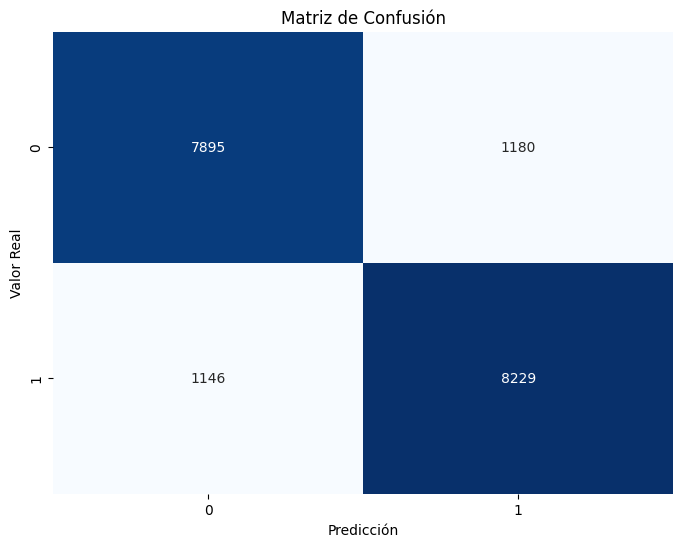

In [ ]:
#Crear el clasificador XGBoost
xgb_classifier = xgb.XGBClassifier()

#Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

#Realizar la búsqueda de hiperparámetros con GridSearchCV y StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=skf, scoring='accuracy')
grid_search.fit(x_train, y_train)

#Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

#Entrenar un clasificador XGBoost con los mejores hiperparámetros en el conjunto de datos completo
best_xgb_classifier = grid_search.best_estimator_
best_xgb_classifier.fit(x_train, y_train)

#Evaluar el rendimiento del clasificador con los mejores hiperparámetros en el conjunto de prueba
test_accuracy = best_xgb_classifier.score(x_test, y_test)
print("Precisión en el conjunto de prueba con los mejores hiperparámetros:", test_accuracy)

# Obtener predicciones en el conjunto de prueba
y_pred = best_xgb_classifier.predict(x_test)

metricas_y_matriz_confusion(y_pred, y_test)

### **Ensambles híbridos**

#### **Voting**

Precisión del ensamble tipo Voting en el conjunto de prueba: 0.7613550135501355
Accuracy: 0.7613550135501355
Recall: 0.7889066666666666
Precision: 0.7531568228105906
f1 score: 0.7706173482677782


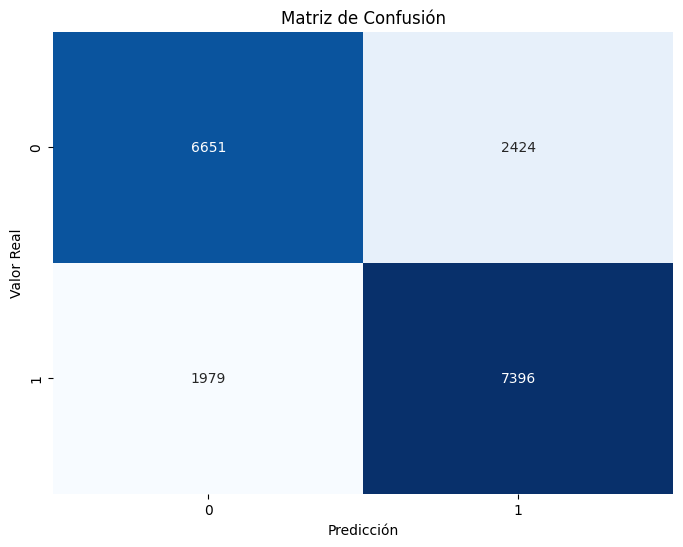

In [ ]:
#Crear el ensamble tipo Voting
ensemble_v = VotingClassifier(estimators=[('rf', rf_classifier), ('knn', best_knn)], voting='soft')

#Entrenar el ensamble en el conjunto de entrenamiento
ensemble_v.fit(x_train, y_train)

#Evaluar el rendimiento del ensamble en el conjunto de prueba
y_pred = ensemble_v.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del ensamble tipo Voting en el conjunto de prueba:", accuracy)

metricas_y_matriz_confusion(y_pred, y_test)

#### **Stacking**

Precisión del ensamble tipo Stacking en el conjunto de prueba: 0.8715989159891598
Accuracy: 0.8715989159891598
Recall: 0.8705066666666667
Precision: 0.8760197509660799
f1 score: 0.8732545075169869


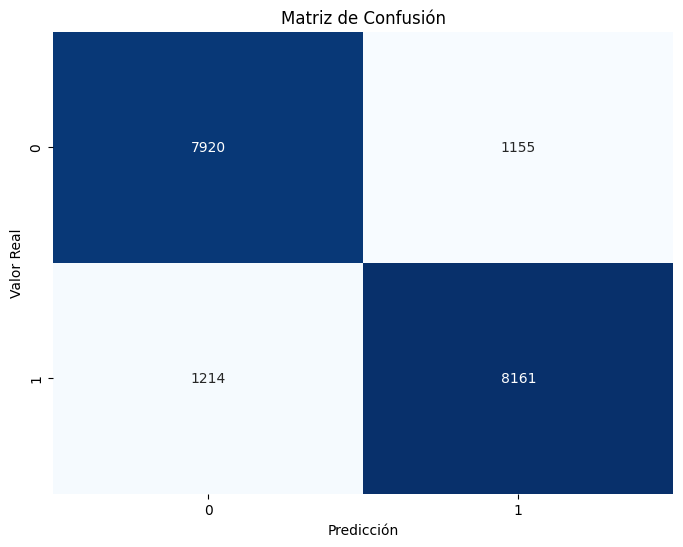

In [ ]:
#Crear el ensamble tipo Stacking
ensemble_s = StackingClassifier(estimators=[('rf', rf_classifier), ('knn', best_knn)], final_estimator=RandomForestClassifier())

#Entrenar el ensamble en el conjunto de entrenamiento
ensemble_s.fit(x_train, y_train)

#Evaluar el rendimiento del ensamble en el conjunto de prueba
y_pred = ensemble_s.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del ensamble tipo Stacking en el conjunto de prueba:", accuracy)

metricas_y_matriz_confusion(y_pred, y_test)

## **Prediccion final**

Seleccionamos el dataset a predecir.

In [ ]:
x_submission = ds_test

Luego de entrenar estos modelos con el dataset de train, vamos a predecir con el test.

In [ ]:
y_pred_final = clf.predict(x_submission)

## **Submission**

Haremos la exportacion de esta prediccion para subirla a la competencia de **kaggle**.

Cargamos el dataset final con las predicciones hechas.

In [ ]:
df_submissing = pd.DataFrame({'id': ds_test_orig['id'], 'is_canceled': y_pred_final.astype(int)})

Finalmente, exportamos.

In [ ]:
df_submissing.to_csv('./submission_chp3_svm_datos_escalados.csv', index=False)